# Decision Trees - Regression Lab

### Mason Nicoletti

Congrats....again! Based off the amazing work you did on the classification model, you've been promoted to chief of all data scientists in Hollywood, your a total celebrity....among data scientists :).  

Your boss, head of the studio, has now asked you to build a model to predict gross revenue in order to help them decide which movies to invest in.

Once again, you would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so...you leverage work you've done in the past to get the job done....you're a data scientist after all! 

#### Target Variable
Target Variable = `gross`

21. Systematic meaning there is a clear difference in the distribution

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

1. Load the data

In [2]:
# Load the Data
movie_data_raw = pd.read_csv("../data/movie_metadata.csv")

2. Ensure all the variables are classified correctly and collapse factor variables as needed.
3. Check for missing variables and correct as needed.

In [3]:
# Modify the movie data preprocessing function
# Combined Steps 2 & 3

def prepare_movie_data(movie_df):
    # Drop NA Rows
    movie_df = movie_df.dropna()

    # Collapse movie directors variable
    top10_director = movie_df.groupby(by='director_name').size().sort_values(ascending=False).head(10)
    movie_df["director_name"] = movie_df['director_name'].apply(lambda x: 1 if x in top10_director else 0).astype("category")
    movie_df = movie_df.rename(columns={'director_name': 'top_director'})

    # Collapse actor_1 variable
    top30_actor = movie_df.groupby(by='actor_1_name').size().sort_values(ascending=False).head(30)
    movie_df["actor_1_name"] = movie_df.actor_1_name.apply(lambda x: 1 if x in top30_actor else 0).astype("category")
    movie_df = movie_df.rename(columns={'actor_1_name': 'top_lead_actor'})

    # Adjust the variable for genres
    genre = ["Drama", "Comedy", "Action", "Horror", "Fantasy", "Documentary", "Crime", "Adventure", "Animation", "Biography"]
    movie_df['genres'] = movie_df['genres'].str.split("|")
    movie_df['genres'] = movie_df.genres.apply(lambda x: x[0] if x[0] in genre else "Other").astype("category")

    # Collapse genre variable
    #movie_df['genres'] = movie_df['genres'].str.split("|").apply(lambda x: x[0])
    #top3_genre = movie_df.groupby(by='genres').size().sort_values(ascending=False).head(3)
    #movie_df["genres"] = movie_df.genres.apply(lambda x: "Top 3" if x in top3_genre else "Other").astype("category")

    # Collapse language variable
    movie_df['language'] = movie_df.language.apply(lambda x: 1 if x=="English" else 0).astype("category")
    movie_df = movie_df.rename(columns={'language': 'language_english'})

    # Collapse country variable
    movie_df['country'] = movie_df.country.apply(lambda x: 1 if x=="USA" else 0).astype("category")
    movie_df = movie_df.rename(columns={'country': 'country_usa'})

    # Collapse rating variable
    ratings = ["PG", "PG-13", "R"]
    movie_df['content_rating'] = movie_df.content_rating.apply(lambda x: x if x in ratings else "Other").astype("category")

    # Drop unnecessary features
    drop_cols = ['color', 'title_year', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes', 'facenumber_in_poster', 'cast_total_facebook_likes', 'movie_title', 'actor_3_name', 'plot_keywords', 'movie_imdb_link', 'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes']
    movie_df = movie_df.drop(columns=drop_cols)

    # Label Encoding
    le_columns = ['content_rating', 'genres']
    label_encoder = LabelEncoder()
    movie_df[le_columns[0]] = label_encoder.fit_transform(movie_df[le_columns[0]])
    movie_df[le_columns[1]] = label_encoder.fit_transform(movie_df[le_columns[1]])

    # Encode categorical variables into numeric
    #category_cols = list(movie_df.select_dtypes('category'))
    #movie_df = pd.get_dummies(movie_df, columns=category_cols, drop_first=True)

    # Classify target variable
    #imdb_score_target = 8.0
    #movie_df['imdb_score'] = movie_df.imdb_score.apply(lambda x: 1 if x >= imdb_score_target else 0).astype('category')

    return movie_df


movie_data = prepare_movie_data(movie_data_raw)

movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3755 entries, 0 to 5042
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   top_director            3755 non-null   category
 1   num_critic_for_reviews  3755 non-null   float64 
 2   duration                3755 non-null   float64 
 3   gross                   3755 non-null   float64 
 4   genres                  3755 non-null   int64   
 5   top_lead_actor          3755 non-null   category
 6   num_voted_users         3755 non-null   int64   
 7   num_user_for_reviews    3755 non-null   float64 
 8   language_english        3755 non-null   category
 9   country_usa             3755 non-null   category
 10  content_rating          3755 non-null   int64   
 11  budget                  3755 non-null   float64 
 12  imdb_score              3755 non-null   float64 
dtypes: category(4), float64(6), int64(3)
memory usage: 308.5 KB


/tmp/ipykernel_897/728829402.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df["director_name"] = movie_df['director_name'].apply(lambda x: 1 if x in top10_director else 0).astype("category")


4. Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

5. Determine the variance of the target variable, is it normally distributed? If not, you may want to transform the target variable. Why might this be important?

In [4]:
# Determine the variance of gross
var_gross = movie_data['gross'].var()
print(var_gross)

4945253136156610.0


6. Split your data into test, tune, and train. (80/10/10)

In [5]:
# Define features and target variable
x = movie_data.drop(columns = 'gross')
y = movie_data['gross']

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=45)

# Split data into test and tune
x_test, x_tune, y_test, y_tune = train_test_split(x_test, y_test, test_size=0.5, random_state=45)

7. Create the kfold object for cross validation.

In [8]:
# Instantiate kfold instance
kf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=45)

8. Create the scoring metric (several measures) you will use to evaluate your model and choose a hyperparamater to optimize.

In [19]:
# Define Scoring Metrics
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Define a hyperparameter
param = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

9. Build the regression tree object.

In [20]:
# Instantiate regression tree object
dt = DecisionTreeRegressor(random_state=45, criterion = 'squared_error')

10. Fit the model to the training data.

In [21]:
# Fit the regression tree
dt_model_1 = dt.fit(x_train, y_train)

11. Explore the results of the model. Print the output of the grid search. What is the best parameter and score?

In [ ]:
# Instantiate Grid Search
search = GridSearchCV(dt, param, scoring=scoring, n_jobs=1, refit='r2', cv=kf)

# Execute the search on the decision tree
dt_model = search.fit(x_train, y_train)


DecisionTreeRegressor(max_depth=4, random_state=45)
    Max Depth  R2 Score  Mean Squared Error  Root Mean Squared Error  \
0           1  0.275327        3.214168e+15             5.669363e+07   
1           2  0.443521        2.467133e+15             4.967024e+07   
2           3  0.521511        2.112668e+15             4.596377e+07   
3           4  0.552257        1.971767e+15             4.440459e+07   
4           5  0.546875        1.989373e+15             4.460239e+07   
5           6  0.544854        1.998178e+15             4.470099e+07   
6           7  0.505135        2.171210e+15             4.659625e+07   
7           8  0.486907        2.244464e+15             4.737577e+07   
8           9  0.459530        2.364878e+15             4.863001e+07   
9          10  0.439780        2.454642e+15             4.954434e+07   
10         11  0.412805        2.571307e+15             5.070806e+07   
11         12  0.394041        2.648559e+15             5.146415e+07   

    Mean Ab

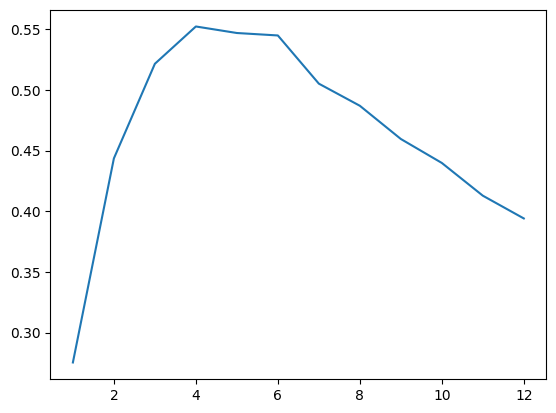

In [ ]:
# Identify the best model
best_model = dt_model.best_estimator_
print(best_model)

# Model Scoring Results
#dt_model.cv_results_


# Extract scores across the various models
mse = abs(dt_model.cv_results_['mean_test_neg_mean_squared_error'])
rmse = np.sqrt(abs(dt_model.cv_results_['mean_test_neg_mean_squared_error']))
r2 = dt_model.cv_results_['mean_test_r2']
mae = abs(dt_model.cv_results_['mean_test_neg_mean_absolute_error'])

# Make df of model scores
dt_model_scoring = pd.DataFrame({"Max Depth": param['max_depth'],
                                 "R2 Score": r2,
                                 "Mean Squared Error": mse,
                                 "Root Mean Squared Error": rmse,
                                 "Mean Absolute Error": mae})

print(dt_model_scoring)

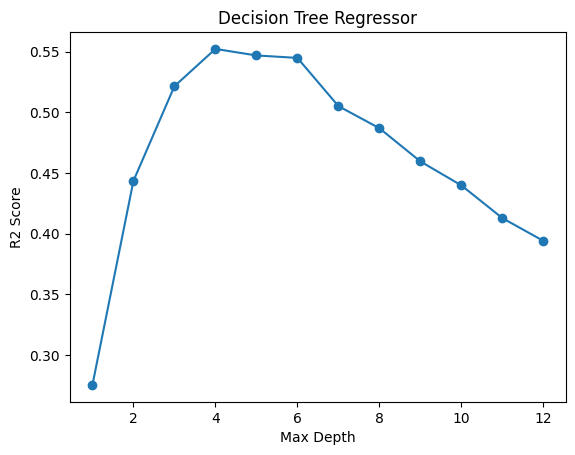

In [53]:
# Plot R2 Score across models
plt.plot(dt_model_scoring['Max Depth'], dt_model_scoring['R2 Score'], '-o')
plt.title("Decision Tree Regressor")
plt.xlabel("Max Depth")
plt.ylabel("R2 Score")
plt.show()

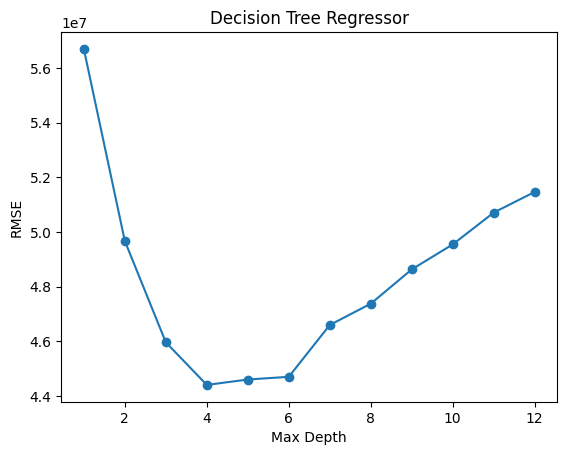

In [ ]:
# Plot RMSE across models
plt.plot(dt_model_scoring['Max Depth'], dt_model_scoring['Root Mean Squared Error'], '-o')
plt.title("Decision Tree Regressor")
plt.xlabel("Max Depth")
plt.ylabel("RMSE")
plt.show()

The best parameter is a max depth of 4. Similarly, the R2 score is the greatest in the model with a depth of 4, and the RMSE and MSE are minimized in this model as well. However, MAE is the smallest in the model with a max depth of 5.